# Plot some WindCube data

In [1]:
import lzma
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import re

import metpy.calc as mpcalc
from metpy.plots import Hodograph
from metpy.units import units
# local module
import mypaths

First, select a date

In [2]:
date = pd.datetime(2018, 2, 14)

## Load data from a zipped file (7z)

In [3]:
inputdir = mypaths.igp_data_dir / 'Windcube'

In [4]:
fname = inputdir / f'WLS866-14_{date:%Y_%m_%d__%H_%M_%S}.sta.7z'

In [5]:
fname.exists()

True

In [6]:
with lzma.open(fname, 'rb') as zf:
    df = pd.read_csv(zf, # uncompressed file buffer
                     header=40, # skip 40 lines
                     delimiter='\t', # tab as delimiter
                     escapechar='\u00B0', # escape degree sign
                     parse_dates=[0], # the first column is date-time
                     index_col=0) # use the first column as index
df = df.reindex(df.index.rename('Time')) # Rename the index column

Check out what is loaded

In [7]:
df.head()

,Int Temp (C),Ext Temp (C),Pressure (hPa),Rel Humidity (%),Wiper count,40m Wind Speed (m/s),40m Wind Speed Dispersion (m/s),40m Wind Speed min (m/s),40m Wind Speed max (m/s),40m Wind Direction (),...,290m Wind Speed min (m/s),290m Wind Speed max (m/s),290m Wind Direction (),290m Z-wind (m/s),290m Z-wind Dispersion (m/s),290m CNR (dB),290m CNR min (dB),290m Dopp Spect Broad (m/s),290m Data Availability (%),Unnamed: 149
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-14 00:10:00,21.10,NaN,NaN,NaN,0,9.33,0.79,7.25,11.74,357.1,...,7.13,11.13,4.4,0.12,0.39,-5.2,-21.5,0.91,46,NaN
2018-02-14 00:20:00,21.08,NaN,NaN,NaN,0,8.87,0.66,6.99,10.49,359.9,...,7.11,11.12,7.1,0.13,0.30,-5.5,-21.3,0.96,26,NaN
2018-02-14 00:30:00,21.07,NaN,NaN,NaN,0,8.29,0.77,6.06,10.51,9.4,...,6.21,10.09,15.9,0.29,0.32,-15.6,-22.0,1.27,27,NaN
2018-02-14 00:40:00,21.08,NaN,NaN,NaN,0,7.99,0.92,4.37,10.34,6.0,...,4.89,10.29,11.9,0.20,0.34,-16.4,-21.9,1.06,30,NaN
2018-02-14 00:50:00,21.07,NaN,NaN,NaN,0,7.83,0.81,6.03,9.97,10.1,...,5.91,9.35,8.4,0.24,0.31,-9.0,-20.9,0.94,37,NaN


In [8]:
# for i in df.columns:
#     print(re.match(r'(?P<height>[0-9]{2,3})m', i).group('height'))

Select wind speed and wind direction

In [9]:
wspd_df = df[[i for i in df.columns if re.match(r'[0-9]{2,3}m Wind Speed \(m/s\)', i)]]
wspd_df.columns = [re.match(r'(?P<height>[0-9]{2,3})m', i).group('height') for i in wspd_df.columns]
wdir_df = df[[i for i in df.columns if re.match(r'[0-9]{2,3}m Wind Direction \(\)', i)]]
wdir_df.columns = [re.match(r'(?P<height>[0-9]{2,3})m', i).group('height') for i in wdir_df.columns]

In [10]:
wdir_df.head()

,40,60,80,100,120,140,160,180,200,230,260,290
Time,,,,,,,,,,,,
2018-02-14 00:10:00,357.1,357.0,358.0,358.9,0.0,1.1,1.5,2.3,2.6,2.7,4.1,4.4
2018-02-14 00:20:00,359.9,359.6,0.4,1.0,1.9,2.5,3.1,3.9,4.3,4.2,5.2,7.1
2018-02-14 00:30:00,9.4,9.2,9.9,10.4,10.5,11.0,11.5,11.8,12.3,13.2,13.5,15.9
2018-02-14 00:40:00,6.0,5.3,5.4,5.9,6.3,7.2,7.4,7.7,8.2,9.8,11.1,11.9
2018-02-14 00:50:00,10.1,8.4,7.7,7.4,7.9,8.0,8.5,9.2,9.2,8.7,8.8,8.4


## Quick look at the wind speed data

Plot the wind speed time series

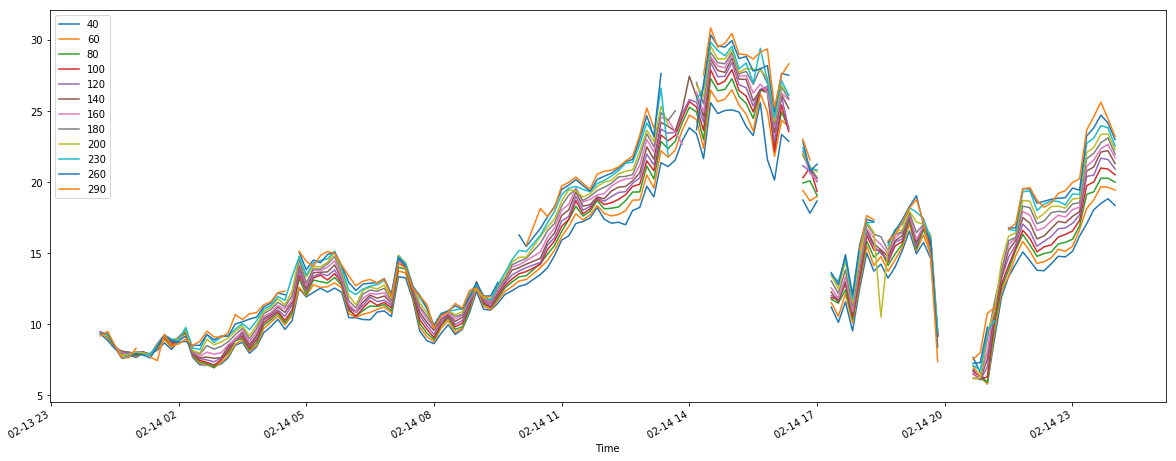

In [11]:
wspd_df.plot(legend=True, figsize=(20, 8));

How to select a specific time range?

In [12]:
dt = pd.datetime(2018,2,14,0)

In [13]:
wspd_df.loc[f'{dt:%Y-%m-%d %H}']

,40,60,80,100,120,140,160,180,200,230,260,290
Time,,,,,,,,,,,,
2018-02-14 00:10:00,9.33,9.45,9.46,9.45,9.48,9.46,9.43,9.38,9.34,9.30,9.28,9.18
2018-02-14 00:20:00,8.87,9.01,9.12,9.23,9.22,9.25,9.19,9.17,9.19,9.30,9.41,9.50
2018-02-14 00:30:00,8.29,8.37,8.40,8.41,8.44,8.47,8.53,8.48,8.47,8.41,8.42,8.55
2018-02-14 00:40:00,7.99,8.12,8.11,8.05,8.01,7.96,7.99,7.88,7.80,7.67,7.61,7.64
2018-02-14 00:50:00,7.83,7.90,8.03,8.03,8.04,7.94,7.88,7.92,7.90,7.82,7.71,7.67


## Convert wind speed and wind direction to u and v components and plot a hodograph

In [14]:
heights = [int(i) for i in wspd_df.columns] * units.m

In [15]:
u, v = mpcalc.get_wind_components(wspd_df.values * units('m/s'), wdir_df.values * units.deg)

In [16]:
# u_df = pd.DataFrame(data=u.m, columns=wspd_df.columns, index=wspd_df.index)

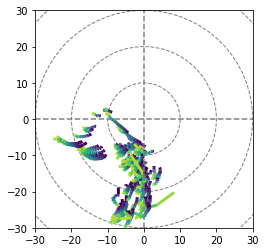

In [17]:
fig, ax = plt.subplots()
h = Hodograph(ax, component_range=30.)
h.add_grid(increment=10)
for iu, iv in zip(u, v):
    if not (np.isnan(iu) & np.isnan(iv)).all():
        ln = h.plot_colormapped(iu, iv, heights)

### Time-Height barb plot

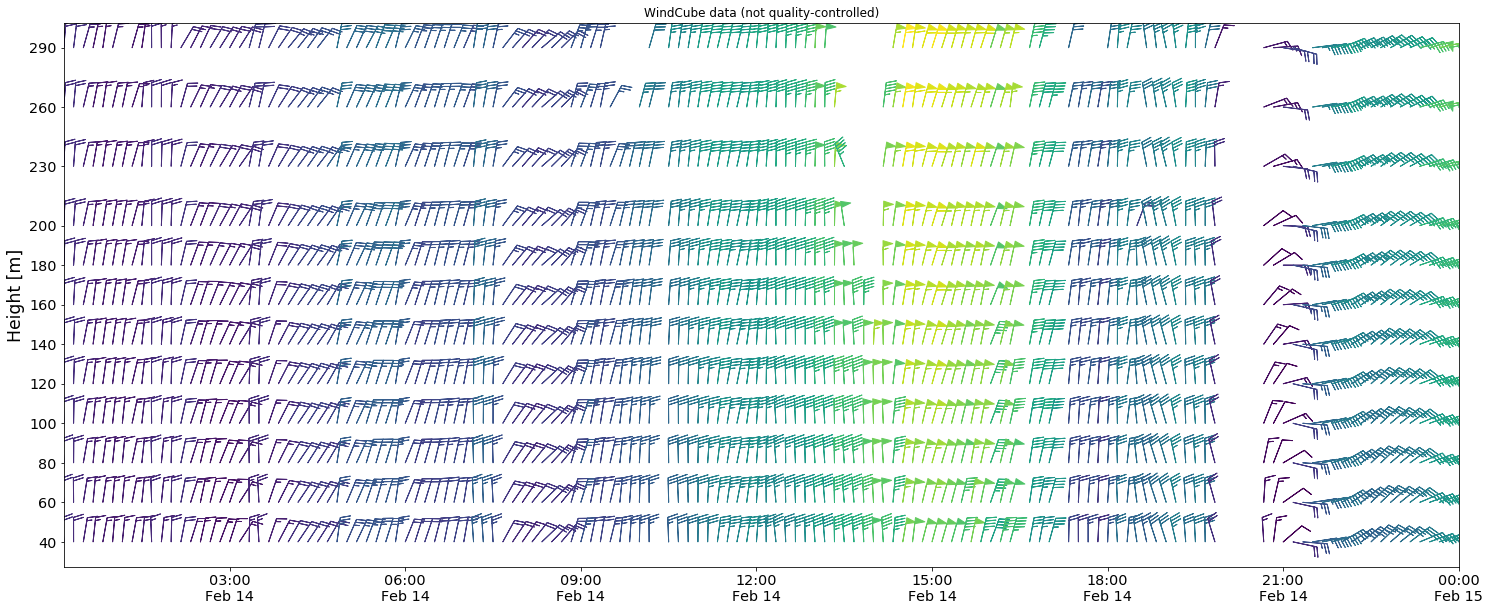

In [18]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.barbs(wspd_df.index, heights, u.T, v.T, wspd_df.values.T,
         barb_increments=dict(half=2.5, full=5, flag=25))
ax.set_xlim([wspd_df.index.min(), wspd_df.index.max()])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %d'))

ax.tick_params(labelsize='x-large')
ax.set_yticks(heights)
ax.set_ylabel('Height [m]', fontsize='xx-large')

ax.set_title('WindCube data (not quality-controlled)');

In [19]:
fig.savefig(mypaths.plotdir/f'windcube_barbs_{date:%Y%m%d}.png', format='png', bbox_inches='tight')